In [ ]:
import subprocess
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from pandas.errors import EmptyDataError
import seaborn as sns
from tqdm import tqdm 

mpl.rcParams['figure.dpi']=300
mpl.rcParams['font.family'] = "Times New Roman"

sns.set()

In [ ]:
class RBPintersect:
    def __init__(self) -> None:
        self.seq_bed_base = './sequence_bed/rinalmo_CosSim{:.1f}-{:.1f}_{}.bed'
        self.rbp_bed_root = '../data/human/CLIP/allRBPbed'
        self.files = os.listdir('./allRBPbed')
        thresh=np.arange(0,0.8,0.1)
        self.thresh=np.append(thresh,1.0)
        self.bed_cols = ['chr','start','end','ENST_ID','some','strand']
        self.meta_df = pd.read_table('./allRBPbed/encore_rbp_metadata.tsv',skiprows=1)

    def run_cmd(self,low_thresh:str,high_thresh:str,utr:str,peak_path):
        seq_bed_path = self.seq_bed_base.format(low_thresh,high_thresh,utr)
        cmd = ['bedtools','intersect','-a',f'{seq_bed_path}','-b',f'{peak_path}','-wo']
        tmp_save_path=seq_bed_path.replace('.bed','_intersec.bed')
        with open(tmp_save_path,'w') as f:
            subprocess.run(cmd,stdout=f)
            f.close()
        try:
            tmp_df = pd.read_table(tmp_save_path,header=None).iloc[:,:len(self.bed_cols)]
        except EmptyDataError:
            tmp_df = pd.DataFrame(None)
        else:
            tmp_df.columns=self.bed_cols
        ## remove tmp file.
        rm_cmd = ['rm',f'{tmp_save_path}']
        subprocess.run(rm_cmd)
        return tmp_df

    def intersect_ratio(self,low_thresh:str,high_thresh:str,utr:str,int_df):
        seq_bed_path = self.seq_bed_base.format(low_thresh,high_thresh,utr)
        total_df = pd.read_table(seq_bed_path,header=None)
        total_sample_size = len(total_df)
        if len(int_df)==0:
            intersect_ratio=0
        else:
            intersect_enst_num = len(int_df['ENST_ID'].unique())
            intersect_ratio = intersect_enst_num/total_sample_size

        return intersect_ratio

    def convert_accession(self,df:pd.DataFrame):
        index=df.index.values
        gene_symbol=[]
        cell = []
        for enc in tqdm(index):
            enc = enc.split(".")[0]
            enc_file=f'/files/{enc}/'
            for a,g,f,b in self.meta_df[['Accession','Target gene symbol','Files','Biosample term name']].values:
                file_cands = f.split(',')
                if enc_file in file_cands:
                    gene_symbol.append(f'{g}')
                    cell.append(b)
        df.index = gene_symbol
        df['cell'] = cell
        return df

    def run(self):
        utr5_total_dict={}
        utr3_total_dict={}
        for bed_path in tqdm(self.files):
            utr5_rbp_dict={}
            utr3_rbp_dict={}
            if '.bed.gz' not in bed_path:
                continue
            else:
                bed_path=os.path.join(self.rbp_bed_root,bed_path)
                for i in range(len(self.thresh)-1):
                    low_thresh=self.thresh[i]
                    high_thresh=self.thresh[i+1]
                    # run for 5utrb
                    utr5_int_df=self.run_cmd(low_thresh,high_thresh,utr='5utr',peak_path=bed_path)
                    utr5_int_ratio = self.intersect_ratio(low_thresh,high_thresh,utr='5utr',int_df=utr5_int_df)
                    utr5_rbp_dict[f'{low_thresh:.1f}-{high_thresh:.1f}']=utr5_int_ratio
                    # run for 3utr
                    utr3_int_df=self.run_cmd(low_thresh,high_thresh,utr='3utr',peak_path=bed_path)
                    utr3_int_ratio = self.intersect_ratio(low_thresh,high_thresh,utr='3utr',int_df=utr3_int_df)
                    utr3_rbp_dict[f'{low_thresh:.1f}-{high_thresh:.1f}']=utr3_int_ratio
            utr5_total_dict[os.path.basename(bed_path)]=utr5_rbp_dict
            utr3_total_dict[os.path.basename(bed_path)]=utr3_rbp_dict

        utr5_total_df = pd.DataFrame(utr5_total_dict).T
        utr3_total_df = pd.DataFrame(utr3_total_dict).T

        utr5_converted_df = self.convert_accession(utr5_total_df)
        utr3_converted_df = self.convert_accession(utr3_total_df)

        return utr5_converted_df,utr3_converted_df

## deduplication of gene.
def deduplication(gene_df):
    init_flg=1
    for gene in gene_df.gene.unique():
        tmp_df = gene_df[gene_df['gene']==gene]
        if len(tmp_df)==1:
            if init_flg==1:
                dedup_df = tmp_df
                init_flg=0
            else:
                dedup_df = pd.concat([dedup_df,tmp_df],axis=0)

        else:
            ## decide remain row
            max_idx = tmp_df['diff'].idxmax()
            rem_df = pd.DataFrame(gene_df.loc[max_idx]).T

            dedup_df = pd.concat([dedup_df,rem_df],axis=0)
    dedup_df=dedup_df.set_index('gene').astype(float)
    dedup_df.sort_values('diff',ascending=False,inplace=True)
    dedup_df.index.name=None

    return dedup_df

In [26]:
intersector = RBPintersect()
utr5_total_df,utr3_total_df = intersector.run()

100%|██████████| 250/250 [00:00<00:00, 1091.00it/s]


In [30]:
utr5_total_df = pd.read_csv('rbp_clustered_utr5.csv',index_col=0)
utr5_total_df['diff'] = utr5_total_df['0.7-1.0']/utr5_total_df['0.0-0.1']
utr5_total_df=utr5_total_df[utr5_total_df['diff']!=float('inf')].fillna(0)
gene_df= utr5_total_df.reset_index().rename(columns={'index':'gene'})
dedup_df = deduplication(gene_df)

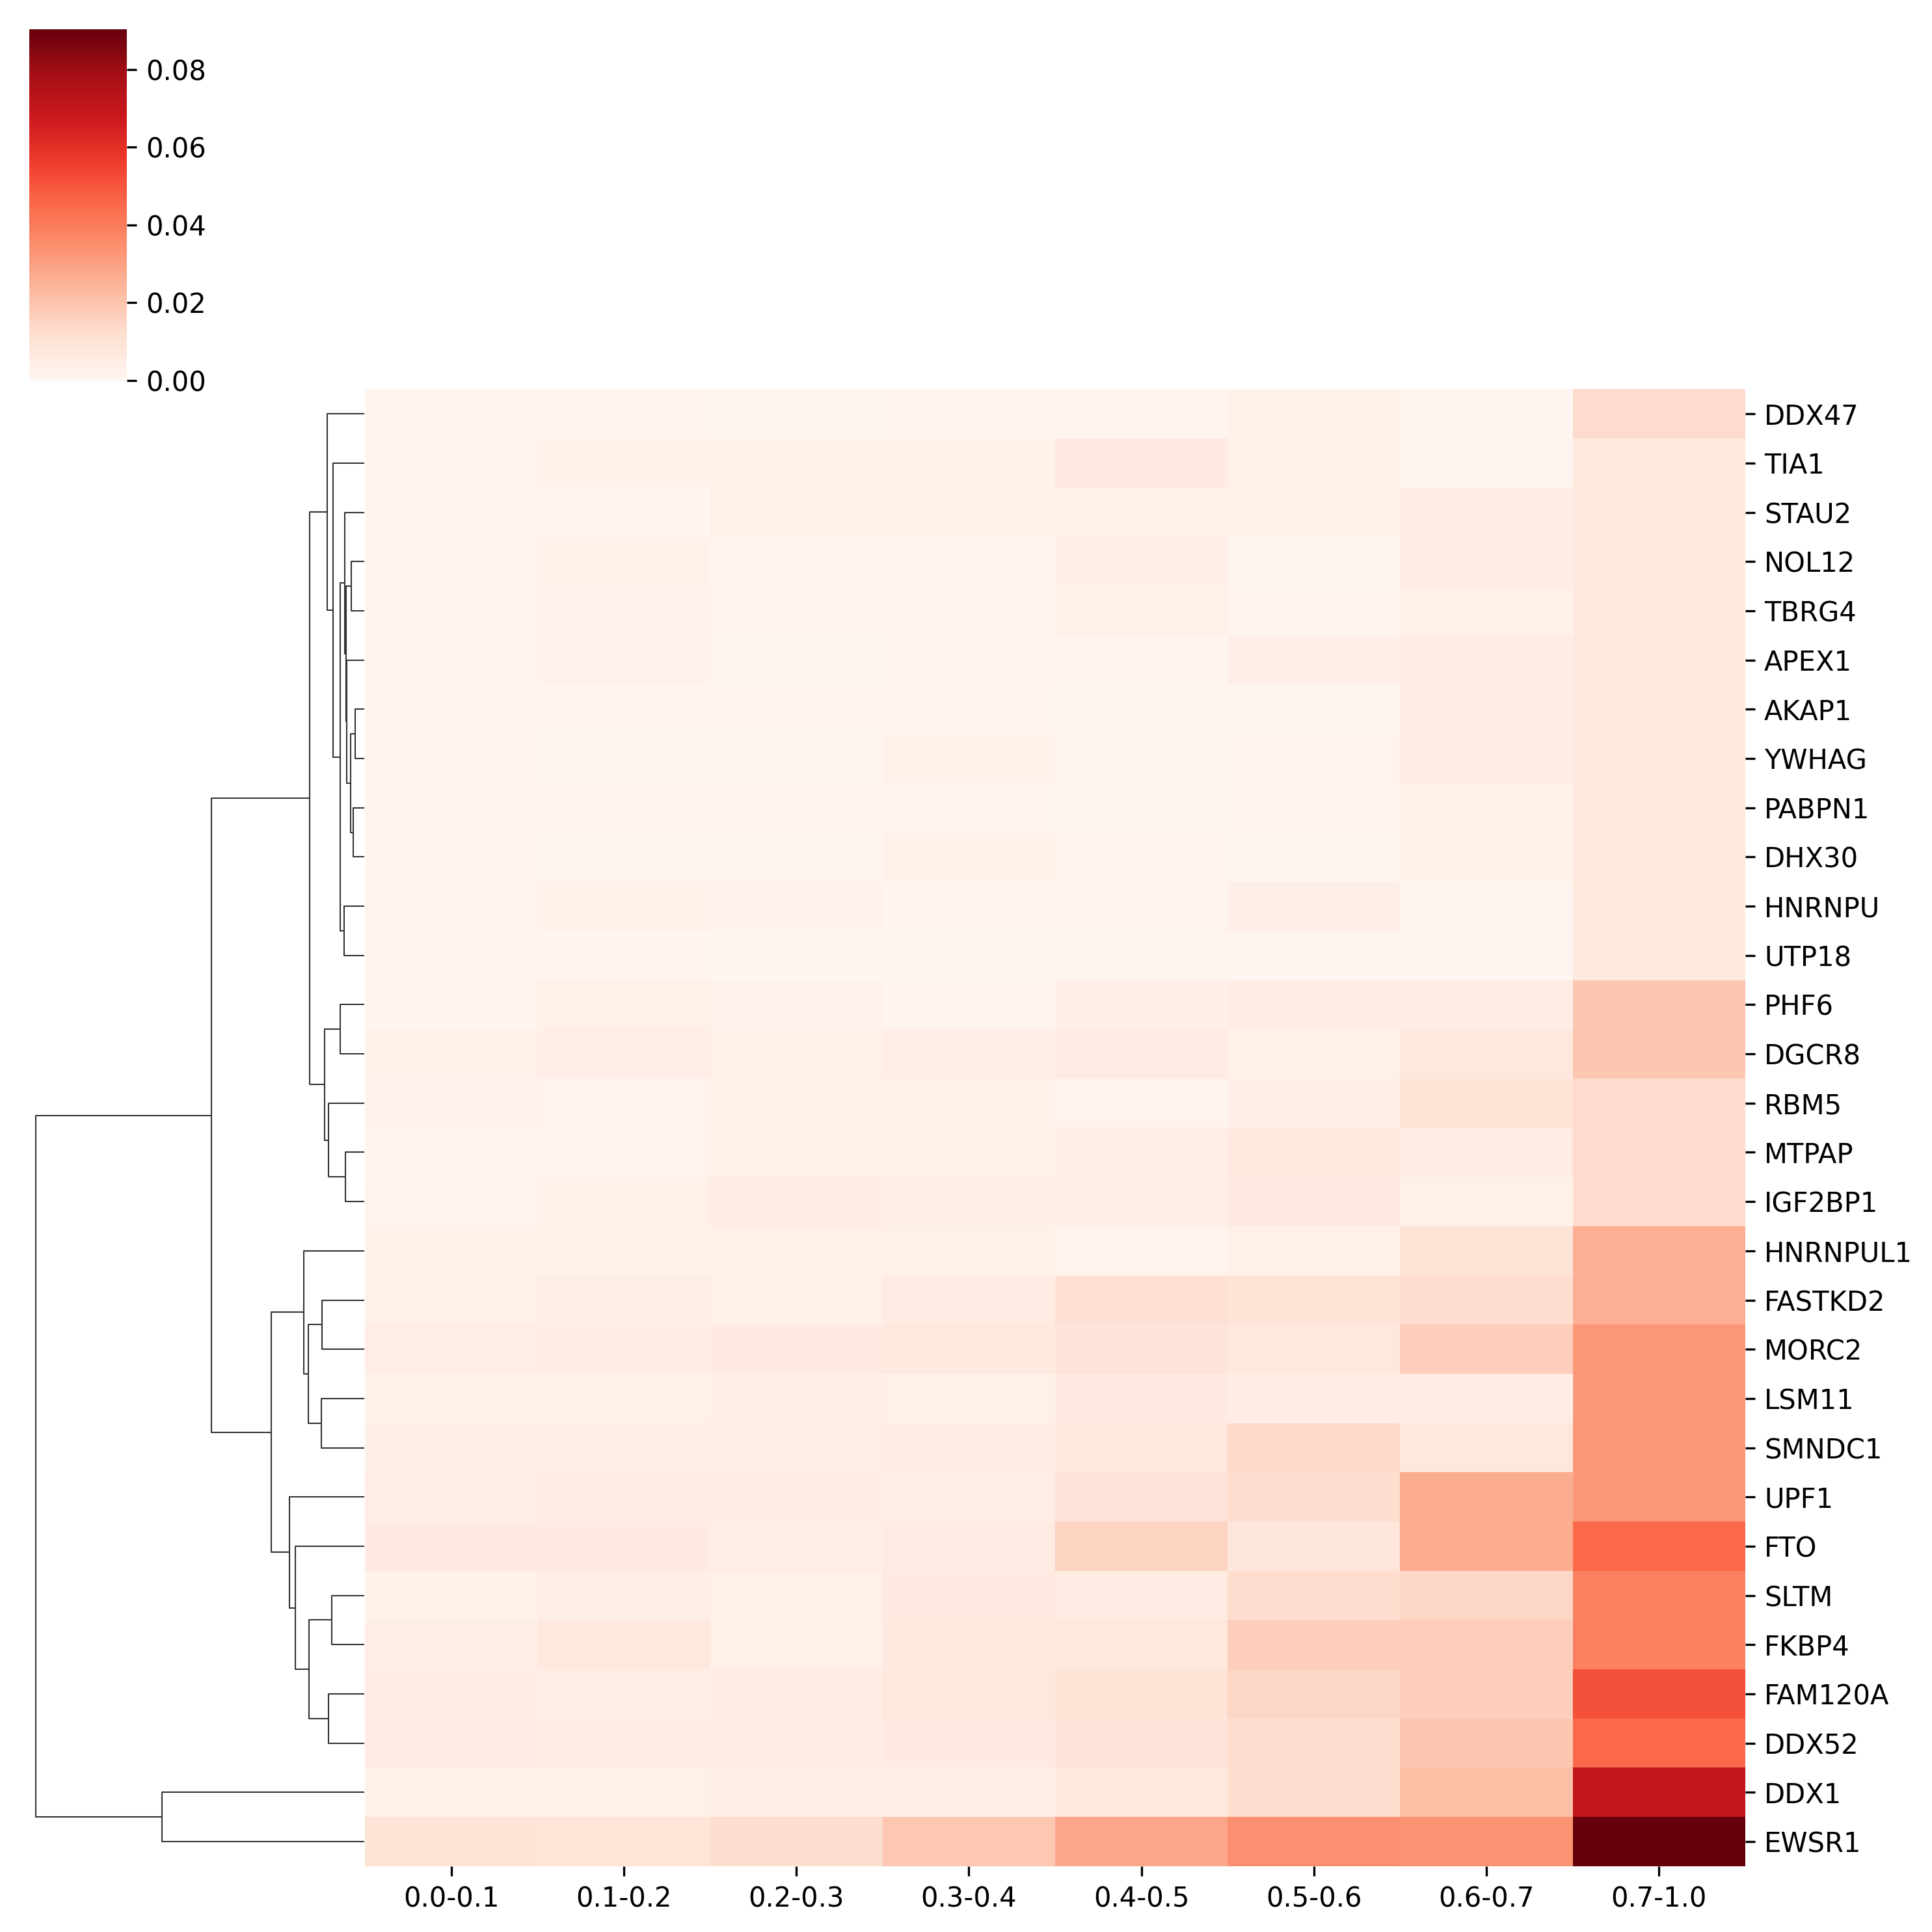

In [31]:
#figsize=(5,5)
p5=sns.clustermap(dedup_df[dedup_df['diff']>3].iloc[:30,:-1],cmap='Reds',col_cluster=False)
plt.savefig('rbp_utr5_difftop30_nodup.png')
#p5=sns.heatmap(dedup_df[dedup_df['diff']>3].iloc[:30,:-1],cmap='Reds')


In [50]:
p5.data2d.reset_index()['index'].to_csv('rbp_utr5_top30_nodup.csv',index=False)

## 3UTR

In [33]:
utr3_total_df = pd.read_csv('rbp_clustered_utr3.csv',index_col=0)
utr3_total_df['diff'] = utr3_total_df['0.7-1.0']/utr3_total_df['0.0-0.1']
utr3_total_df=utr3_total_df[utr3_total_df['diff']!=float('inf')].fillna(0)
gene_df3= utr3_total_df.reset_index().rename(columns={'index':'gene'})
dedup_df = deduplication(gene_df3)

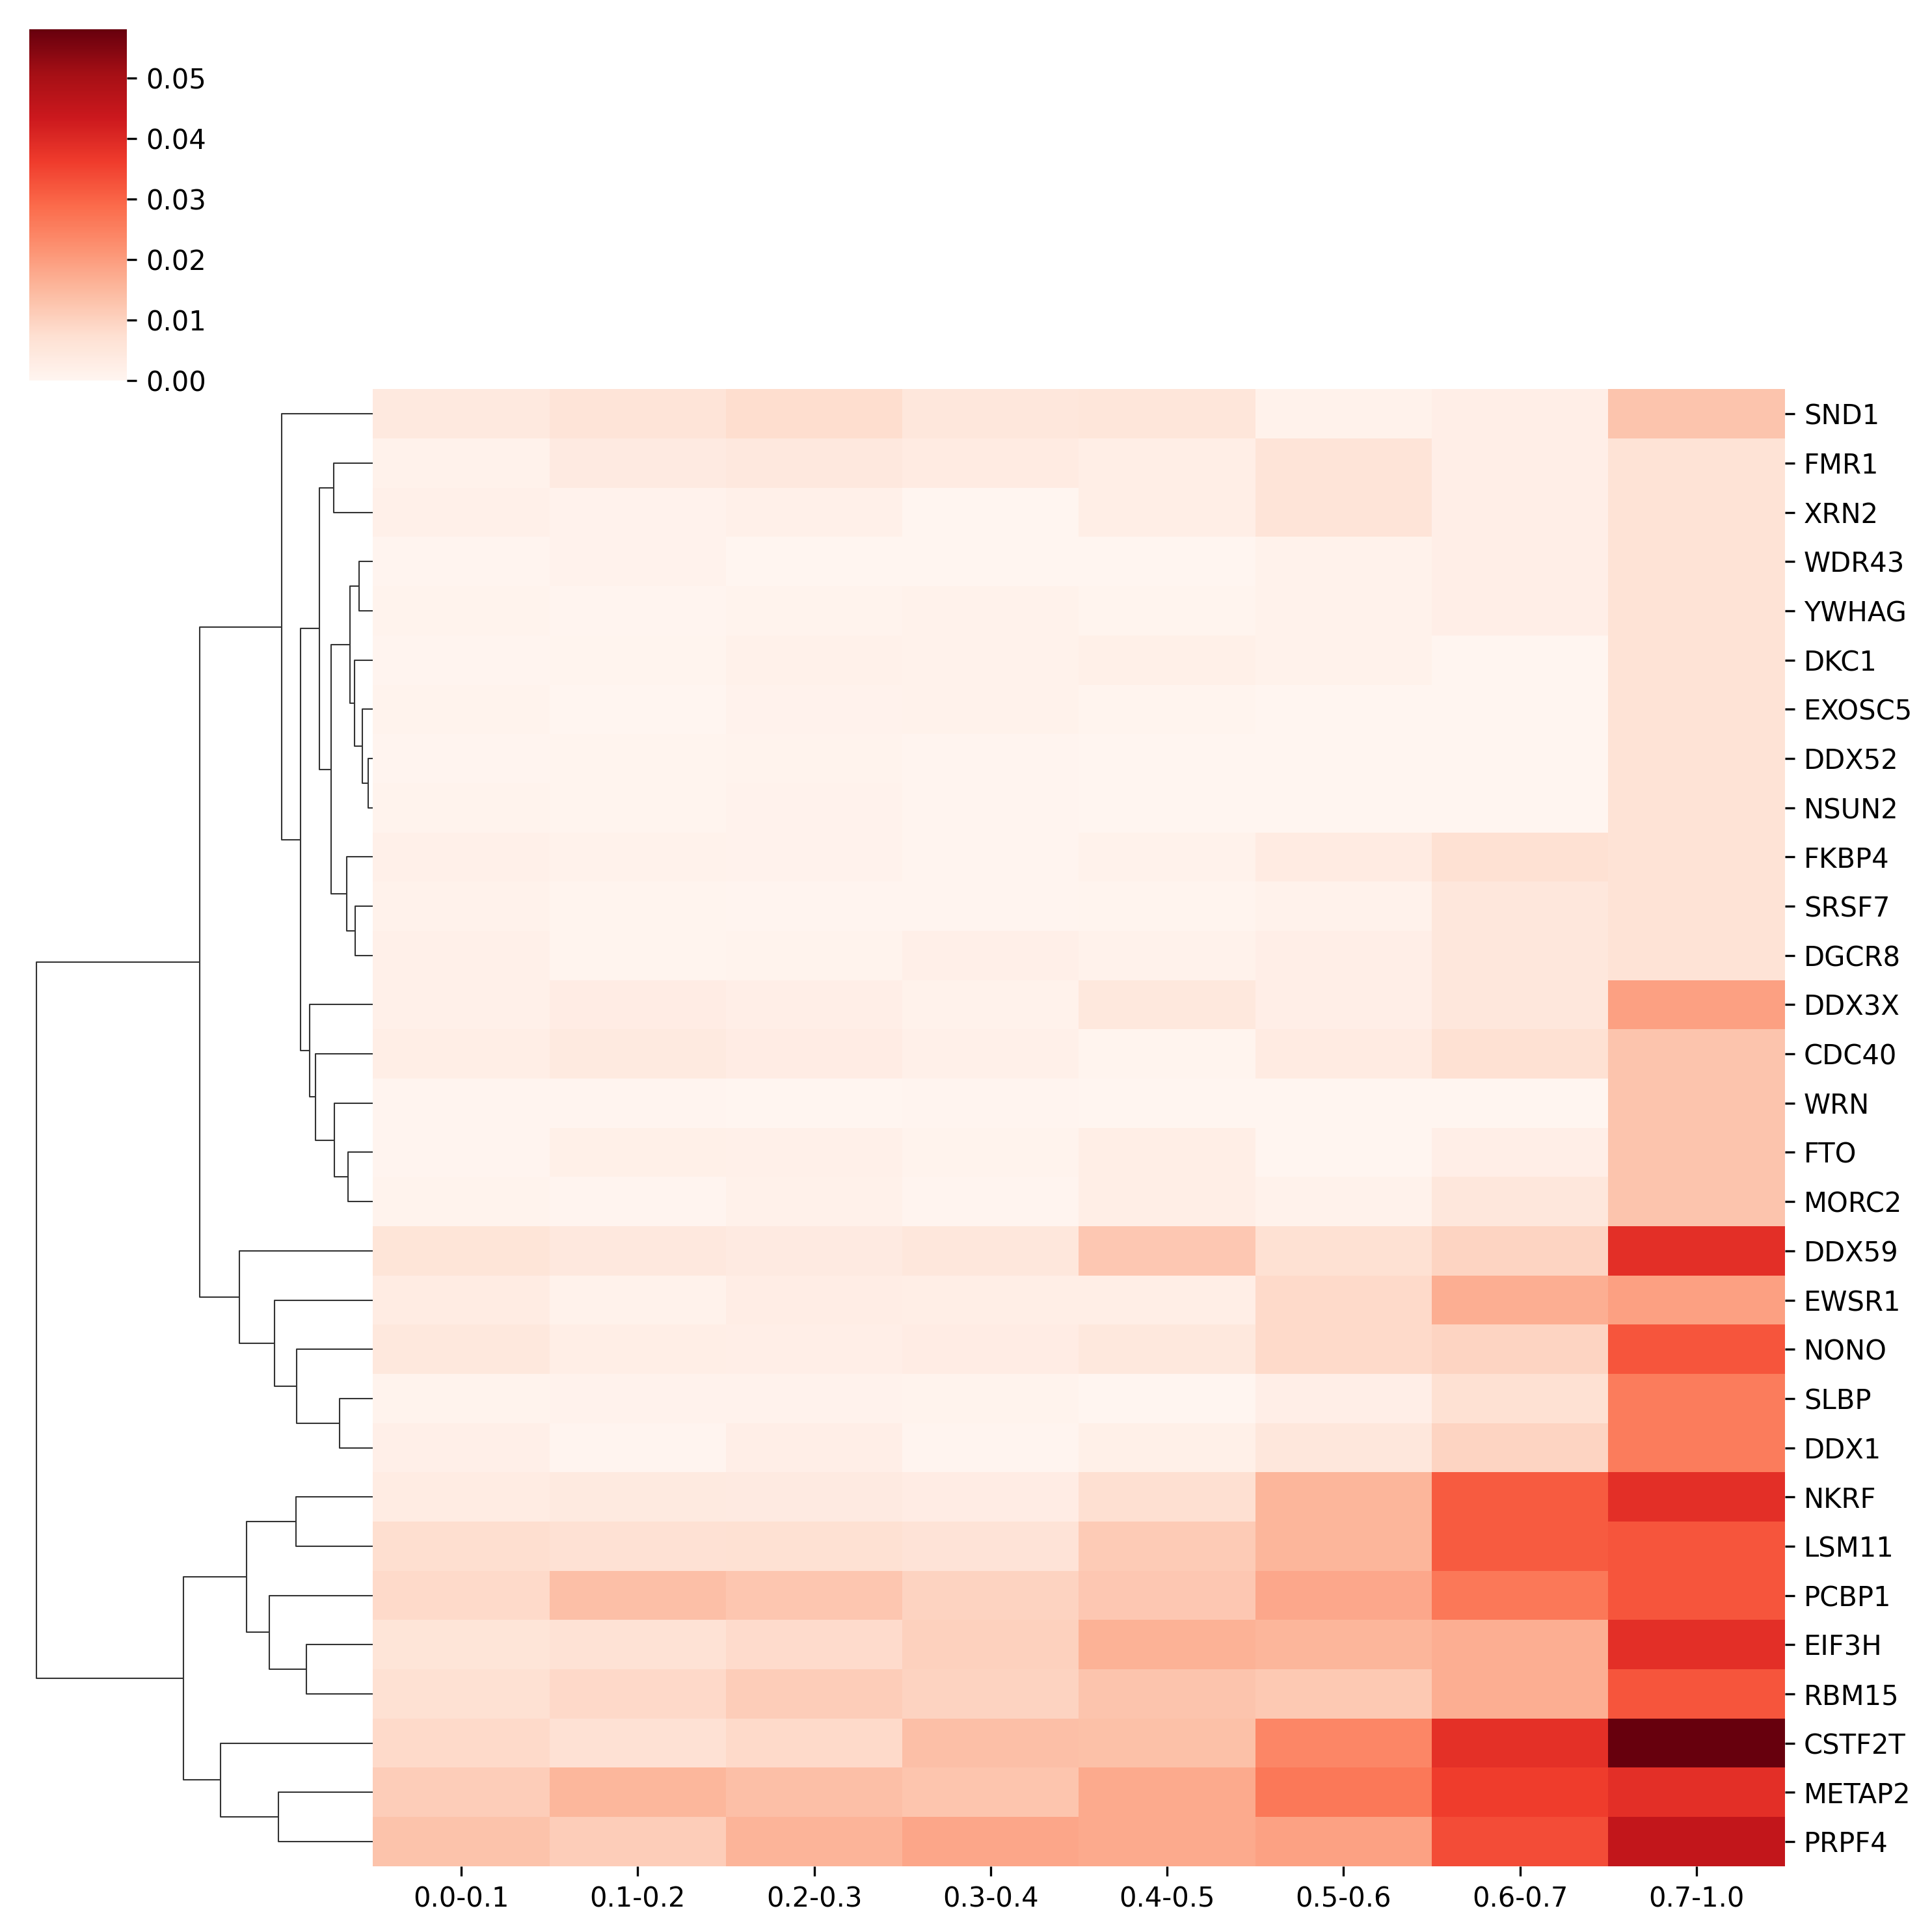

In [60]:
p3=sns.clustermap(dedup_df[dedup_df['diff']>3].iloc[:30,:-1],cmap='Reds',col_cluster=False)
#plt.title('3UTR')
plt.savefig('rbp_utr3_difftop30_nodup.png')
#p3.cax.set_visible(False)

#plt.tight_layout()

In [9]:
p3.data2d.reset_index()['index'].to_csv('rbp_utr3_top30_nodup.csv',index=False)

# Gene Enrichment

### 5UTR

In [4]:
go_df = pd.read_csv('/home/ksuga/whole_mrna_predictor/UTR_PairPred/data/human/CLIP/metascape_rbp_5utr_difftop30_nodup/Enrichment_GO/GO_membership.csv')
go_child_df_selected = go_df[go_df['GO'].str.contains('GO:')].sort_values('_LogP_index',ascending=False).iloc[-5:]

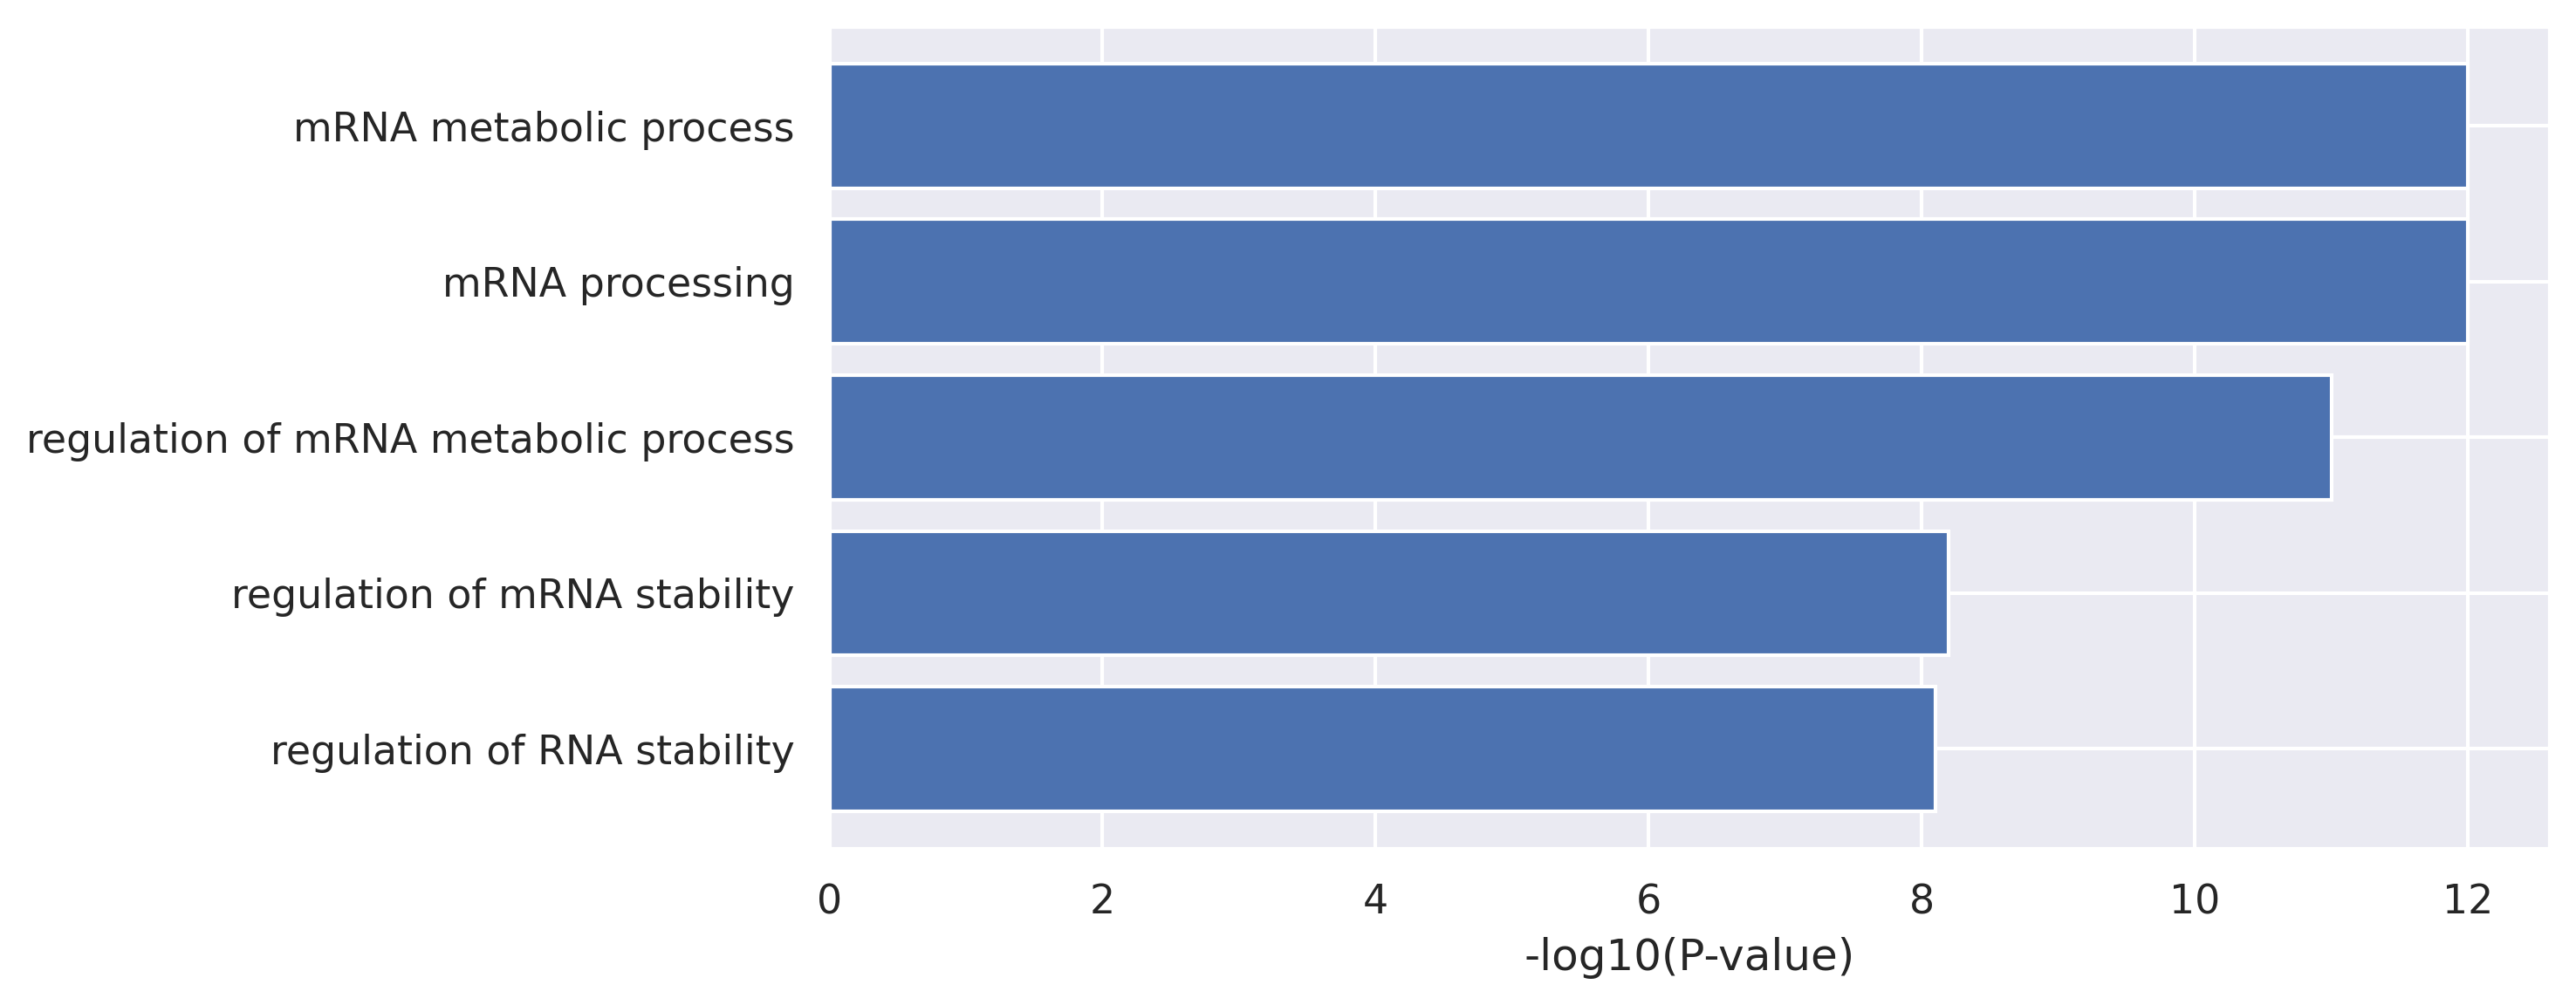

In [9]:
labels = go_child_df_selected['Description']
plt.figure(figsize=(10,4))
plt.barh(y=np.arange(len(go_child_df_selected)),width= -go_child_df_selected['_LogP_index'],tick_label=labels)
plt.xlabel('-log10(P-value)')
plt.tight_layout()

plt.savefig('/home/ksuga/whole_mrna_predictor/UTR_PairPred/data/human/CLIP/metascape_rbp_5utr_difftop30_nodup/barh_rbp_5utr_top5_GO_seaborn.png')

### 3UTR

In [10]:
go_df = pd.read_csv('/home/ksuga/whole_mrna_predictor/UTR_PairPred/data/human/CLIP/metascape_rbp_3utr_difftop30_nodup/Enrichment_GO/GO_membership.csv')
go_child_df_selected = go_df[go_df['GO'].str.contains('GO:')].sort_values('_LogP_index',ascending=False).iloc[-5:]

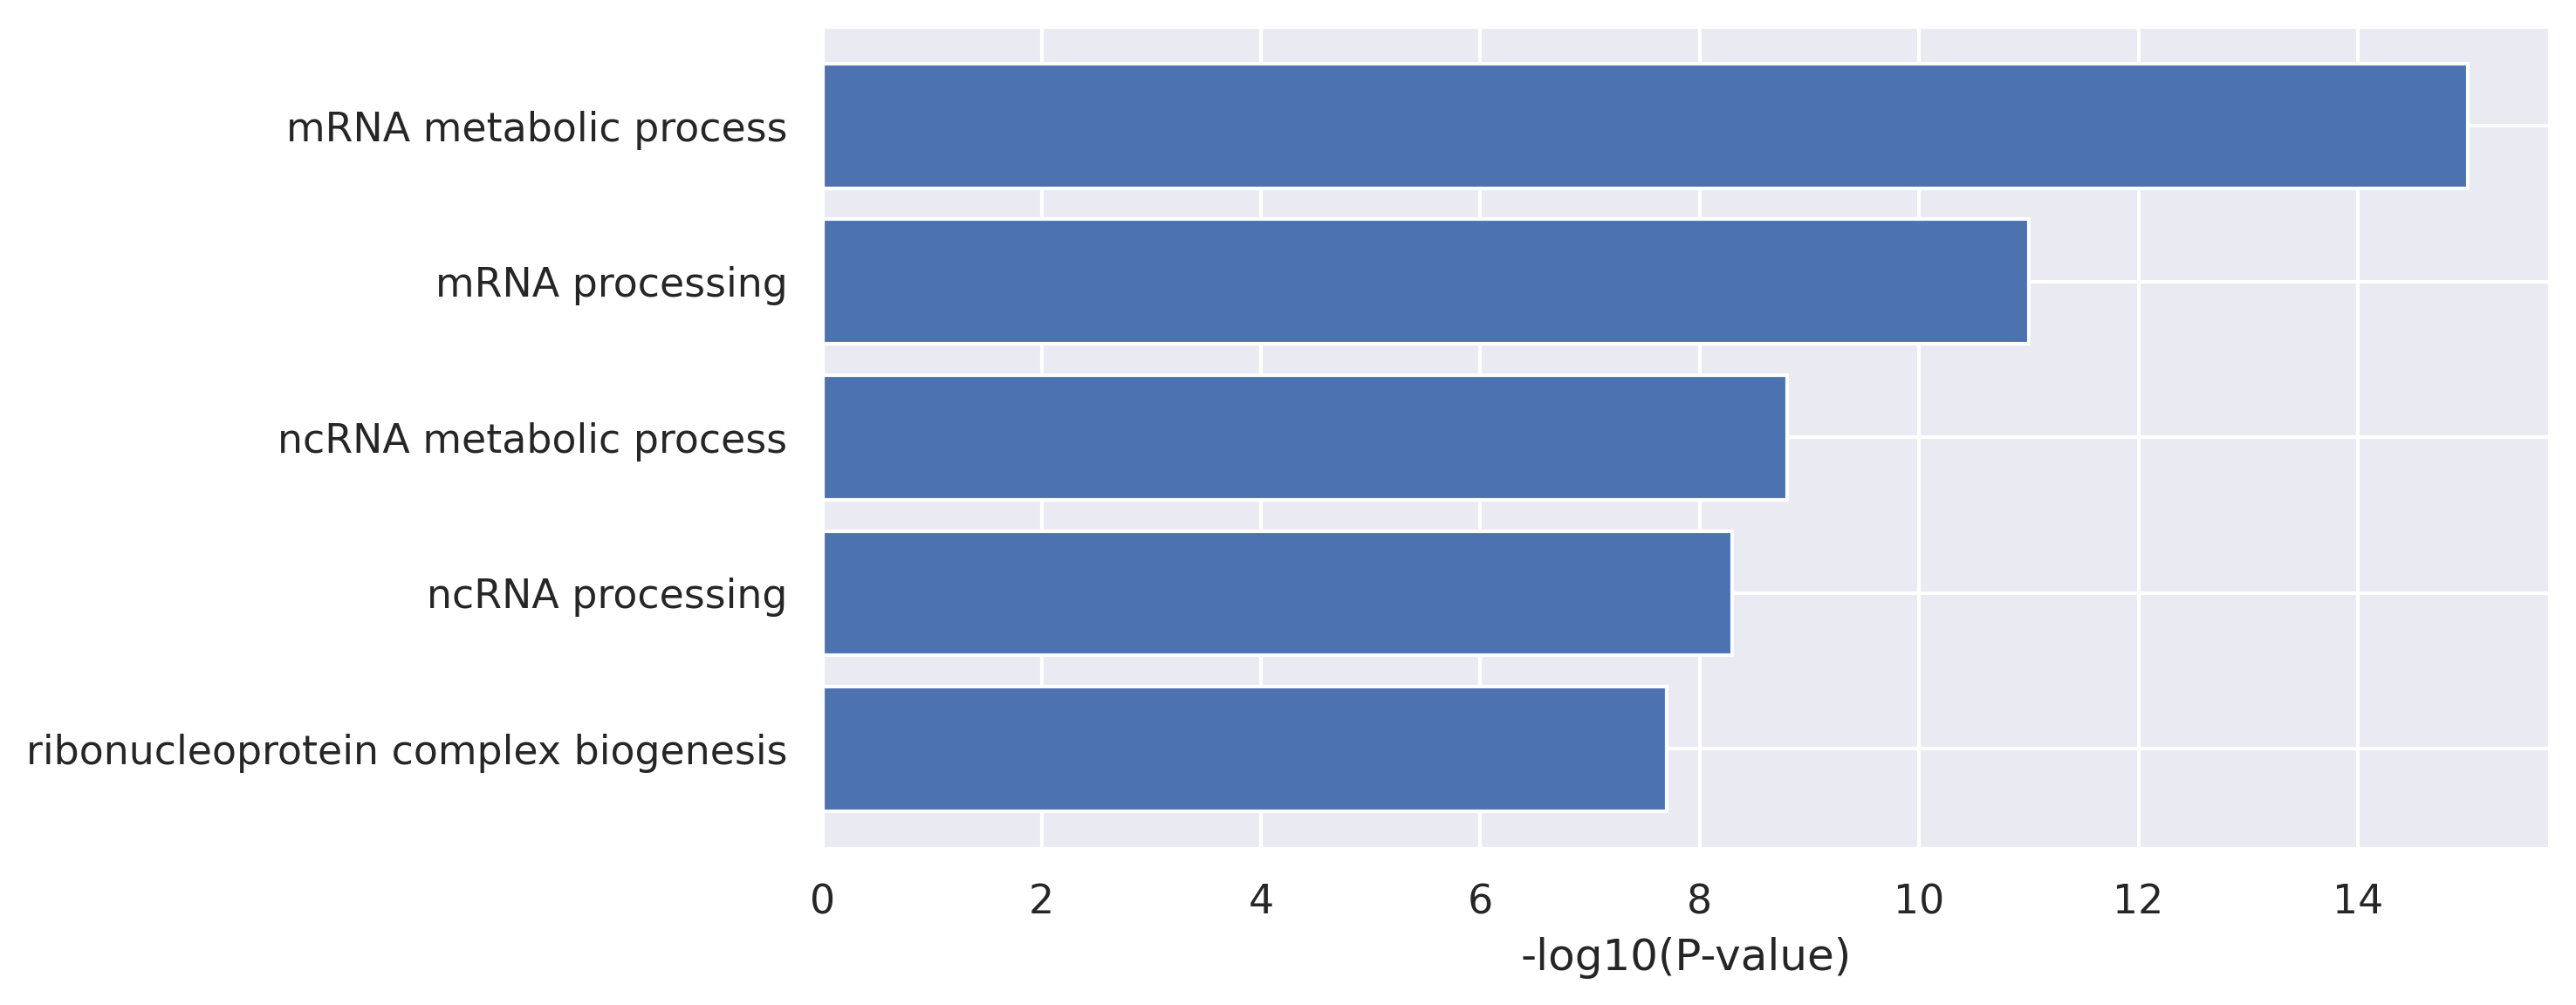

In [ ]:
labels = go_child_df_selected['Description']
plt.figure(figsize=(10,4))
plt.barh(y=np.arange(len(go_child_df_selected)),width= -go_child_df_selected['_LogP_index'],tick_label=labels)
plt.xlabel('-log10(P-value)')
plt.tight_layout()

plt.savefig('/home/ksuga/whole_mrna_predictor/UTR_PairPred/data/human/CLIP/metascape_rbp_3utr_difftop30_nodup/barh_rbp_3utrtop5_GO_seaborn.png')